# $NicheVI-workflow$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker
from scvi.strip_metrics import SpatialAnalysis

In [3]:
scvi.settings.seed = 34

Global seed set to 34


In [1]:
from scvi.data import synthetic_iid

adatas = synthetic_iid(
        batch_size=10,
        n_genes=100,
        n_proteins=0,
        n_regions=0,
        n_batches=2,
        n_labels=3,
        dropout_ratio=0.5,
        coordinates_key="coordinates",
        sparse_format=None,
        return_mudata=False,
    )

In [2]:
adatas

AnnData object with n_obs × n_vars = 20 × 100
    obs: 'batch', 'labels'
    obsm: 'coordinates'

In [4]:
adatas.obs.batch

0     batch_0
1     batch_0
2     batch_0
3     batch_0
4     batch_0
5     batch_0
6     batch_0
7     batch_0
8     batch_0
9     batch_0
10    batch_1
11    batch_1
12    batch_1
13    batch_1
14    batch_1
15    batch_1
16    batch_1
17    batch_1
18    batch_1
19    batch_1
Name: batch, dtype: category
Categories (2, object): ['batch_0', 'batch_1']

In [5]:
!ls /home/nathanlevy/Data/

ls: cannot access /home/nathanlevy/Data/: No such file or directory


In [67]:
plots = True

In [40]:
data_dirs = {
    "VIZGEN_Liver": [
        "/home/nathanlevy/Data/Liver_VIZGEN/",
        "liver-joint-scvi3-annotated.h5ad"
    ],
    "MERFISH_Brain": [
        "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/",
        "adata_scvi_merfish4w.h5ad"
    ],
    "NANOSTRING_Lung": [
        "/home/nathanlevy/Data/",
        "nanostring_bis_finished_hotspot_densities.h5ad"
    ]
}

In [3]:
# data_dir = "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/"
# data_file = "adata_scvi_merfish4w.h5ad"

data_dir, data_file = data_dirs["MERFISH_Brain"]

data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)

NameError: name 'data_dirs' is not defined

In [74]:
path_to_save = os.path.join("checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

In [69]:
adata = ad.read_h5ad(data_dir + data_file)
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [50]:
adata.X = adata.layers["counts"]  # putting in the X matrtix the raw counts
adata.obs["cell_type"] = adata.obs['annotation']

# subset the data to only include the samples we want to analyze: Liver1Slice1 and Liver2Slice1
adata = adata[
    adata.obs["sample"].isin(["Liver1Slice1", "Liver2Slice1"])
].copy()

In [70]:
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
# for sample in adata.obs.donor_slice.unique().tolist()[:1]:
#     sc.pl.spatial(
#         adata[adata.obs.donor_slice == sample],
#         spot_size=40,
#         color=["cell_type", "donor_id"],
#         ncols=2,
#         frameon=False,
#         title=sample,
#     )

## First train (linear)scVI

In [108]:
N_LAYERS = 1
N_LATENT = 10
LIKELIHOOD = "poisson"
N_EPOCHS = 150
WEIGHT_DECAY = 1e-6
WARMUP = 0
BATCH_KEY = "donor_id"

In [79]:
lvae_is_trained = True
save_lvae = True

if lvae_is_trained:
    vae = scvi.model.LinearSCVI.load(
        dir_path=path_to_save + "/lvae_E" + str(N_EPOCHS) + ".pt", adata=adata
    )

if lvae_is_trained == False:
    scvi.model.LinearSCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key=BATCH_KEY,
    )

    vae = scvi.model.LinearSCVI(
        adata,
        gene_likelihood=LIKELIHOOD,
        n_layers=N_LAYERS,
        n_latent=N_LATENT,
    )

    vae.train(
        max_epochs=N_EPOCHS,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=WARMUP, weight_decay=WEIGHT_DECAY),
        early_stopping=True,
    )

    if save_lvae:
        vae.save(
            dir_path=path_to_save + "/lvae_E" + str(N_EPOCHS) + ".pt",
            save_anndata=False,
        )

INFO     File checkpoints/adata_scvi_merfish4w/lvae_E110.pt/model.pt already downloaded                            


In [ ]:
vae.summary_stats

n_batch: 4
n_cells: 123632
n_labels: 1
n_vars: 374

In [76]:
adata.obsm["qz1_m"], adata.obsm["qz1_var"] = vae.get_latent_representation(
    return_dist=True
)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


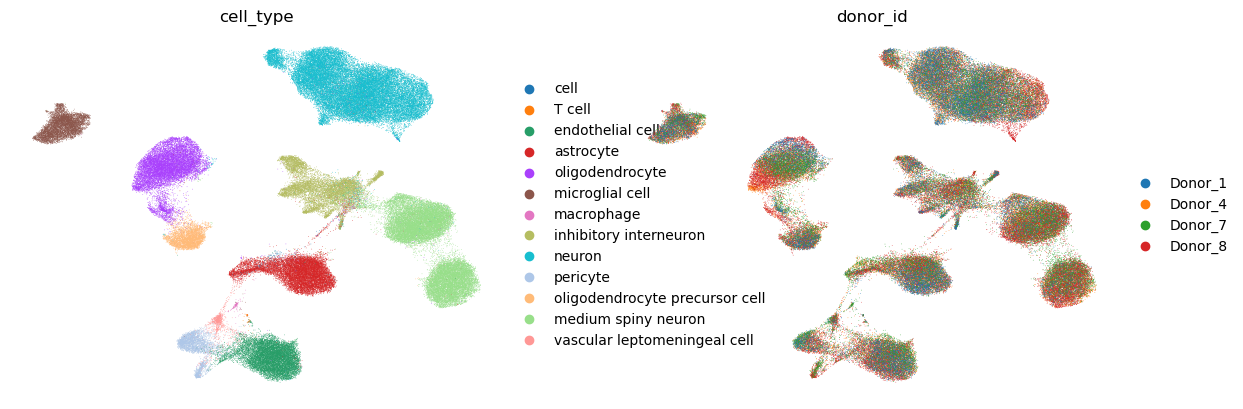

In [ ]:
if plots:
    sc.pp.neighbors(adata, use_rep="qz1_m")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "donor_id"],
        ncols=2,
        frameon=False,
    )

In [ ]:
vae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

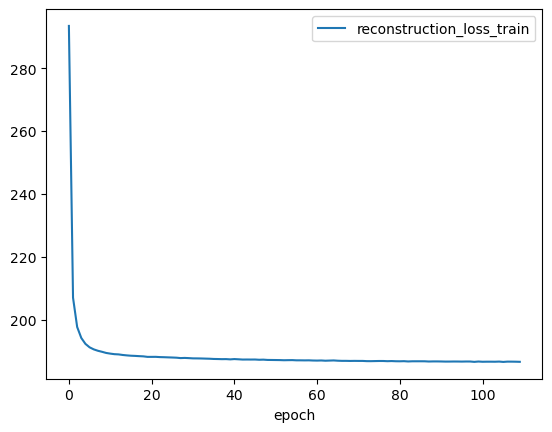

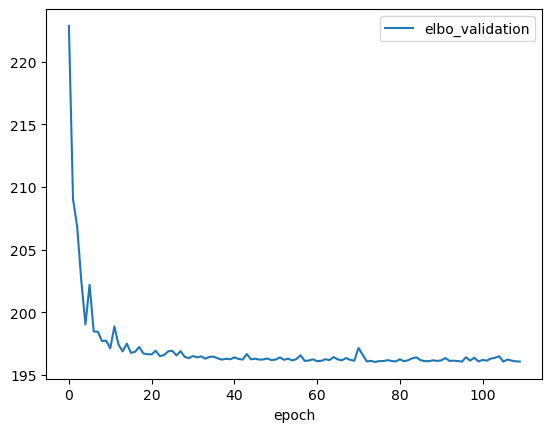

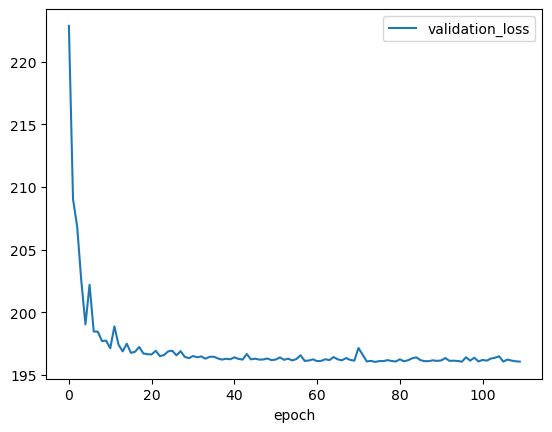

In [ ]:
vae.history["reconstruction_loss_train"].plot()
vae.history["elbo_validation"].plot()
vae.history["validation_loss"].plot()

In [80]:
is_trained = True
save_scvi = True

if is_trained == False:
    scvi.model.SCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key=BATCH_KEY,
    )

    scvivae = scvi.model.SCVI(
        adata,
        gene_likelihood=LIKELIHOOD,
        n_layers=N_LAYERS,
        n_latent=N_LATENT,
    )

    scvivae.train(
        max_epochs=N_EPOCHS,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=WARMUP, weight_decay=WEIGHT_DECAY),
        early_stopping=True,
    )

    if save_scvi:
        scvivae.save(
            dir_path=path_to_save + "/scvivae_E" + str(N_EPOCHS) + ".pt",
            save_anndata=False,
        )

if is_trained:
    scvivae = scvi.model.SCVI.load(
        dir_path=path_to_save + "/scvivae_E" + str(N_EPOCHS) + ".pt", adata=adata
    )

adata.obsm["X_scVI"] = scvivae.get_latent_representation()

INFO     File checkpoints/adata_scvi_merfish4w/scvivae_E110.pt/model.pt already downloaded                         


<Axes: xlabel='epoch'>

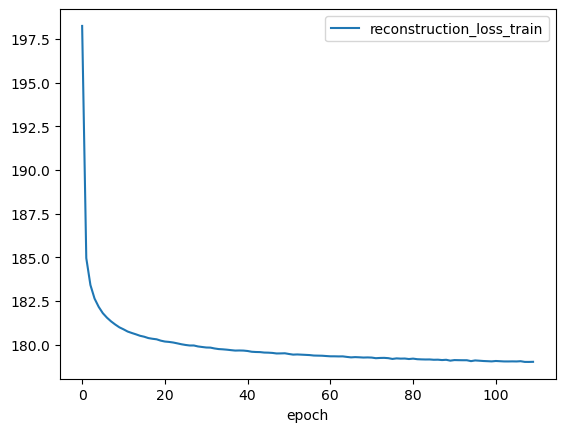

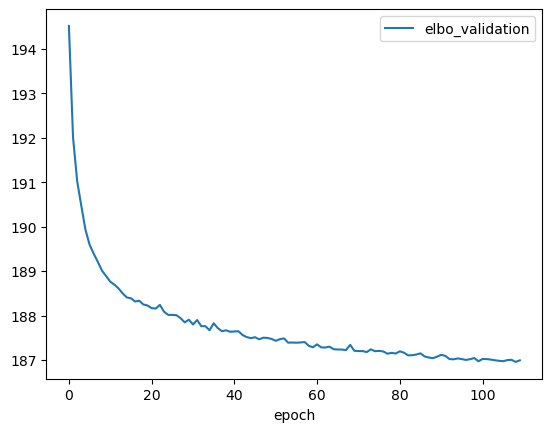

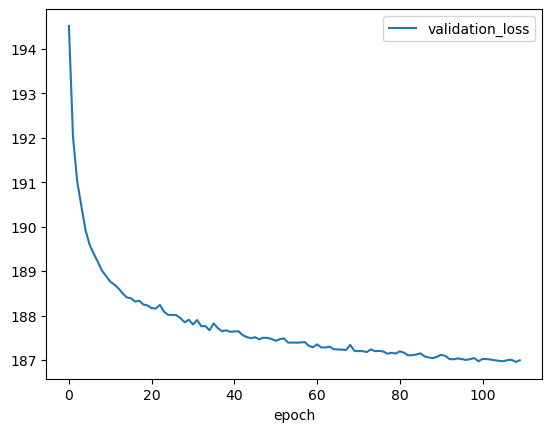

In [ ]:
scvivae.history["reconstruction_loss_train"].plot()
scvivae.history["elbo_validation"].plot()
scvivae.history["validation_loss"].plot()

## Then train $nicheVI$

Parameters

In [81]:
K_NN = 20
# n_latent_z1 = adata.obsm["qz1_var"].shape[1]
N_LAYERS_NICHE = 1
N_LAYERS_COMPO = 1
SAMPLE_KEY = "donor_slice"

In [82]:
print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var

In [83]:
# preprocessing function to populate adata.obsm with the keys 'neighborhood_composition',
# 'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct',
# 'qz1_var_niche_ct'

scvi.model.nicheSCVI.preprocessing_anndata(
    adata,
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    label_key="cell_type",
    sample_key=SAMPLE_KEY,
    cell_coordinates_key="centroids",
    k_nn=K_NN,
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_niche_keys=["qz1_m_niche_ct"],
    latent_var_niche_keys=["qz1_var_niche_ct"],
)

Saved niche_indexes and niche_distances in adata.obsm
Saved niche_composition in adata.obsm
Saved qz1_m_niche_ct and qz1_var_niche_ct in adata.obsm


In [84]:
adata.obsm["qz1_m_niche_ct"].shape

(123632, 13, 10)

In [85]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, 
spatial, qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct)

In [86]:
scvi.model.nicheSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key=BATCH_KEY,
    labels_key="cell_type",
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_ct_key="qz1_m_niche_ct",
    latent_var_ct_key="qz1_var_niche_ct",
)

INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [107]:
niche_setup = {
    # "mix_kl0_compo0": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 0,
    #     "niche_compo_weight": 0,
    # },
    # "mix_unif_kl0_compo0": {
    #     "niche_components": "cell_type_unweighted",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 0,
    #     "niche_compo_weight": 0,
    # },
    "mix_e1_kl1_compo1": {
        "niche_components": "cell_type",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 1,
        "niche_compo_weight": 1,
        "n_layers_niche": 1,
        "n_layers_compo": 1,
    },
    # "mixL_e1_kl1_compo1": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 1,
    #     "niche_compo_weight": 1,
    #     "n_layers_niche": 2,
    #     "n_layers_compo": 2,
    # },
    # "mix_unif_kl1_compo1": {
    #     "niche_components": "cell_type_unweighted",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 1,
    #     "niche_compo_weight": 1,
    # },
    # "mix_kl10_compo10": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 10,
    #     "niche_compo_weight": 10,
    # },
    # "mix_unif_kl10_compo10": {
    #     "niche_components": "cell_type_unweighted",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 10,
    #     "niche_compo_weight": 10,
    # },
    "mix_e1_kl50_compo50": {
        "niche_components": "cell_type",
        "niche_combination": "mixture",
        "elbo_weight": 1,
        "niche_kl_weight": 50,
        "niche_compo_weight": 50,
        "n_layers_niche": 1,
        "n_layers_compo": 1,
    },
    # "mix_unif_kl50_compo50": {
    #     "niche_components": "cell_type_unweighted",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 50,
    #     "niche_compo_weight": 50,
    # },
    # "mix_e1_kl50_compo0": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 1,
    #     "niche_kl_weight": 50,
    #     "niche_compo_weight": 0,
    # },
    # "mix_e0_kl1_compo0": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 0,
    #     "niche_kl_weight": 1,
    #     "niche_compo_weight": 0,
    # },
    # "mix_e0_kl1_compo1": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 0,
    #     "niche_kl_weight": 1,
    #     "niche_compo_weight": 1,
    # },
    # "mix_e0_kl0_compo1": {
    #     "niche_components": "cell_type",
    #     "niche_combination": "mixture",
    #     "elbo_weight": 0,
    #     "niche_kl_weight": 0,
    #     "niche_compo_weight": 1,
    # },
}

In [109]:
nichevae_is_trained = False
save_pt = True
history_setup = {}

In [110]:
for setup in niche_setup.keys():
    print(setup)
    setup_dict = niche_setup[setup]

    if nichevae_is_trained == False:
        nichevae = scvi.model.nicheSCVI(
            adata,
            elbo_weight=setup_dict["elbo_weight"],
            niche_kl_weight=setup_dict["niche_kl_weight"],
            niche_compo_weight=setup_dict["niche_compo_weight"],
            niche_components=setup_dict["niche_components"],
            niche_combination=setup_dict["niche_combination"],
            gene_likelihood=LIKELIHOOD,
            n_layers=N_LAYERS,
            n_layers_niche=setup_dict["n_layers_niche"],
            n_layers_compo=setup_dict["n_layers_compo"],
            n_latent=N_LATENT,
            use_batch_norm="both",
            use_layer_norm="none",
        )

        nichevae.train(
            max_epochs=N_EPOCHS,
            train_size=0.8,
            validation_size=0.2,
            plan_kwargs=dict(n_epochs_kl_warmup=WARMUP, weight_decay=WEIGHT_DECAY),
            early_stopping=True,
            batch_size=128,
        )

        if save_pt:
            nichevae.save(
                dir_path=path_to_save
                + "/nichevae_"
                + setup
                + "_"
                + str(N_EPOCHS)
                + ".pt",
                save_anndata=False
                # dir_path="./checkpoints/nichevae_" + setup + "_.pt", save_anndata=False
                # path_to_save + "/lvae_E" + str(N_EPOCHS) + ".pt"
            )

    if nichevae_is_trained:
        nichevae = scvi.model.nicheSCVI.load(
            dir_path=path_to_save + "/nichevae_" + setup + "_" + str(N_EPOCHS) + ".pt",
            adata=adata,
        )

    history_setup[setup] = nichevae.history
    adata.obsm[setup + "_X_nicheVI"] = nichevae.get_latent_representation()

mix_e1_kl1_compo1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 150/150: 100%|██████████| 150/150 [15:11<00:00,  5.95s/it, v_num=1, train_loss_step=201, train_loss_epoch=190]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [15:11<00:00,  6.08s/it, v_num=1, train_loss_step=201, train_loss_epoch=190]


mix_e1_kl50_compo50

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████| 150/150 [15:08<00:00,  6.11s/it, v_num=1, train_loss_step=291, train_loss_epoch=292]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [15:08<00:00,  6.05s/it, v_num=1, train_loss_step=291, train_loss_epoch=292]


In [71]:
history_setup.keys()

dict_keys(['mix_e1_kl1_compo1', 'mixL_e1_kl1_compo1', 'mix_e1_kl50_compo50'])

<Axes: xlabel='epoch'>

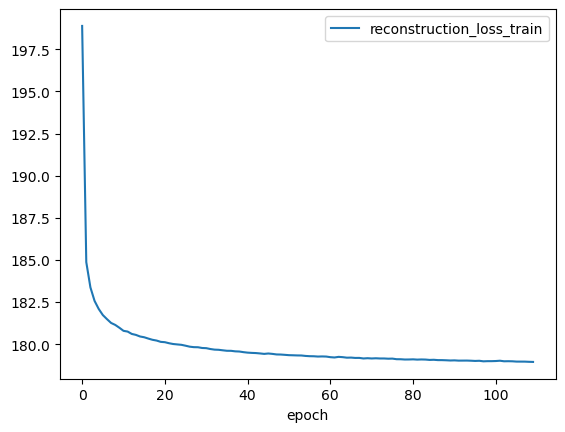

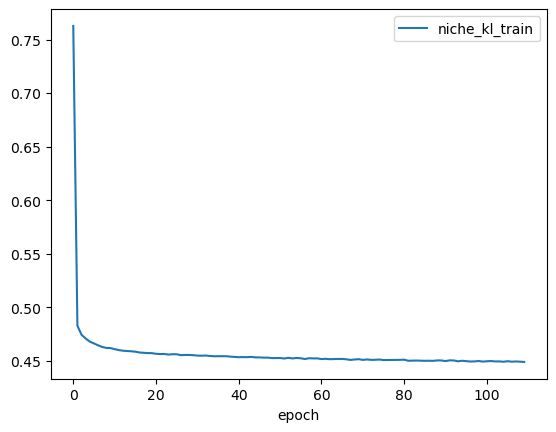

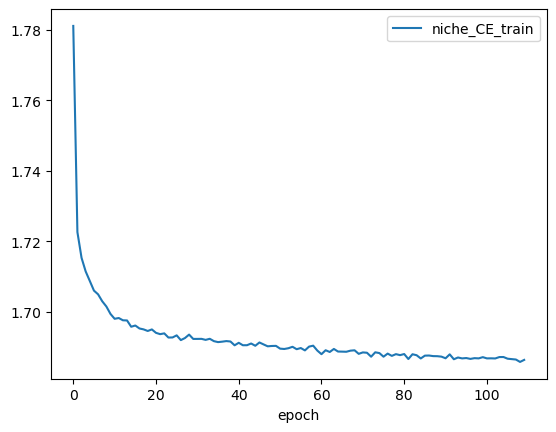

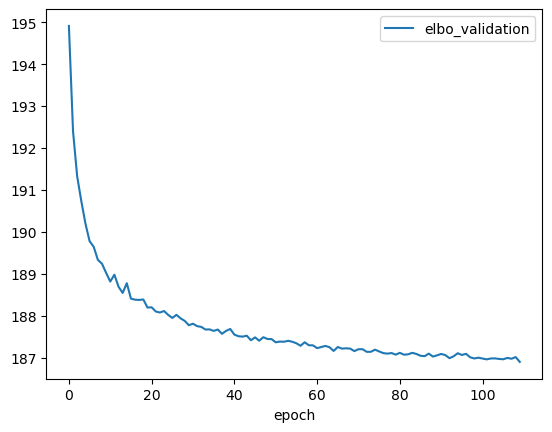

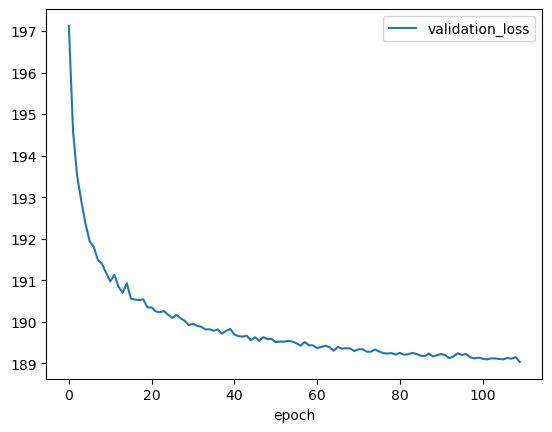

In [88]:
# nichevae.history["reconstruction_loss_train"].plot()
# nichevae.history["niche_kl_train"].plot()

# key = "mix_unif_kl0_compo0"
key = "mixL_e1_kl1_compo1"

history_setup[key]["reconstruction_loss_train"].plot()
history_setup[key]["niche_kl_train"].plot()
history_setup[key]["niche_CE_train"].plot()
history_setup[key]["elbo_validation"].plot()
history_setup[key]["validation_loss"].plot()

In [26]:
# key = "mix_unif_kl10_compo10"

# history_setup[key]["reconstruction_loss_train"].plot()
# history_setup[key]["niche_kl_train"].plot()
# history_setup[key]["niche_CE_train"].plot()
# history_setup[key]["elbo_validation"].plot()

In [39]:
# history_setup['cell_type_setup_mixture']['kl_local_train'].plot()

In [73]:
print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct, mix_e1_kl1_compo1_X_nicheVI, 
mixL_e1_kl1_compo1_X_nicheVI, mix_e1_kl50_compo50_X_nicheVI

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


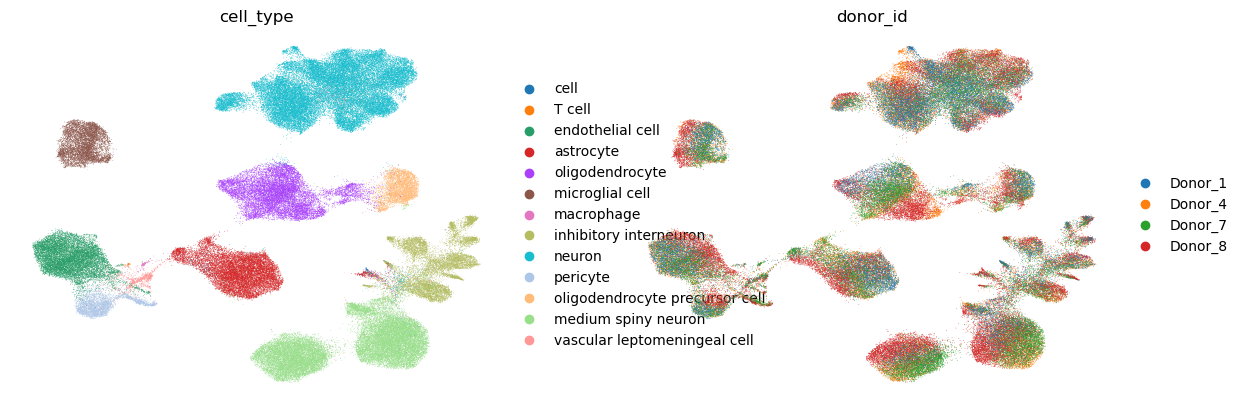

In [26]:
sc.pp.neighbors(adata, use_rep="mix_e1_kl50_compo50_X_nicheVI")
sc.tl.umap(adata, min_dist=0.3)


sc.pl.umap(
    adata,
    color=["cell_type", "donor_id"],
    ncols=2,
    frameon=False,
)

## scib-metrics

In [27]:
adata.obsm["X_ldvae"] = adata.obsm["qz1_m"]
# adata.obsm["X_scVI"] = scvivae.get_latent_representation()

print(adata.obsm)

AxisArrays with keys: X_pca, X_scVI, X_spVI, X_spatial, X_umap, centroids, neighborhood_composition, spatial, 
qz1_m, qz1_var, niche_indexes, niche_distances, qz1_m_niche_ct, qz1_var_niche_ct, mix_e1_kl1_compo1_X_nicheVI, 
mixL_e1_kl1_compo1_X_nicheVI, mix_e1_kl50_compo50_X_nicheVI, X_ldvae

In [28]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="cell_type",
    embedding_obsm_keys=[
        # "X_pca",
        "X_ldvae",
        "X_scVI",
        # "mix_unif_kl10_compo10_X_nicheVI",
        # "mix_kl10_compo10_X_nicheVI",
        # "mix_unif_kl0_compo0_X_nicheVI",
        # "mix_kl0_compo0_X_nicheVI",
        # "mix_unif_kl1_compo1_X_nicheVI",
        "mix_e1_kl1_compo1_X_nicheVI",
        # "mix_unif_kl50_compo50_X_nicheVI",
        # "mix_kl50_compo50_X_nicheVI",
        "mix_e1_kl50_compo50_X_nicheVI",
        "mixL_e1_kl1_compo1_X_nicheVI",
        # "mix_e0_kl1_compo1_X_nicheVI",
        # "mix_e0_kl0_compo1_X_nicheVI",
    ],
    n_jobs=-1,
)
bm.benchmark()

Computing neighbors:   0%|          | 0/5 [00:00<?, ?it/s]

Embeddings: 100%|██████████| 5/5 [28:39<00:00, 343.97s/it]


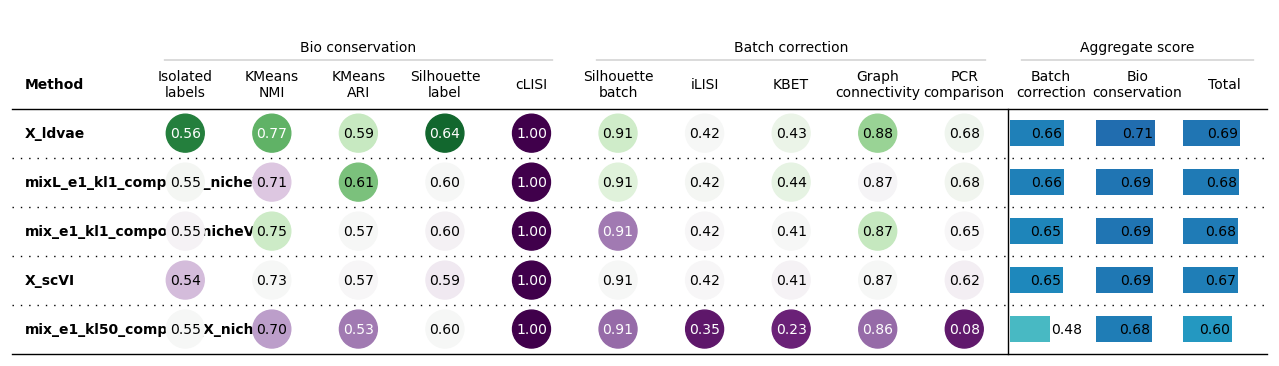

In [29]:
bm.plot_results_table(min_max_scale=False)

In [46]:
# df = bm.get_results(min_max_scale=False)
# print(df)

## spatial metrics

In [104]:
sa = SpatialAnalysis(
    adata=adata,
    label_key="cell_type",
    sample_key="donor_slice",
    latent_space_keys=[
        "X_ldvae",
        "X_scVI",
        # # "mix_unif_kl10_compo10_X_nicheVI",
        # "mix_kl10_compo10_X_nicheVI",
        # # "mix_unif_kl0_compo0_X_nicheVI",
        # "mix_kl0_compo0_X_nicheVI",
        # # "mix_unif_kl1_compo1_X_nicheVI",
        # "mix_kl1_compo1_X_nicheVI",
        # # "mix_unif_kl50_compo50_X_nicheVI",
        # "mix_kl50_compo50_X_nicheVI",
        "mix_e1_kl50_compo50_X_nicheVI",
        "mix_e1_kl1_compo1_X_nicheVI",
        "mixL_e1_kl1_compo1_X_nicheVI",
        # "mix_e0_kl0_compo1_X_nicheVI",
    ],
    spatial_coord_key="centroids",
    ct_composition_key="neighborhood_composition",
    z1_reference="X_scVI",
    z2_comparison="mix_e1_kl50_compo50_X_nicheVI",
)

In [32]:
sa.compute_metrics(
    k_nn=40,  # what is the optimal k_nn?
    set_of_metrics=["distance", "similarity"],
    similarity_metric="spearman",
    reduction=["median", "mean"],
    # z2_versus_z1=["X_scVI", "mix_kl50_compo50_X_nicheVI"],
)

X_ldvae

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:58<00:00, 29.90s/it]


Saved latent and physical correlation in the adata.obs column latent_and_phys_corr_X_ldvae.

Saved compositional neighborhood similarity in the adata.obs column neighborhood_similarity_X_ldvae.

X_scVI

100%|██████████| 10/10 [04:58<00:00, 29.84s/it]


Saved latent and physical correlation in the adata.obs column latent_and_phys_corr_X_scVI.

Saved compositional neighborhood similarity in the adata.obs column neighborhood_similarity_X_scVI.

mix_e1_kl50_compo50_X_nicheVI

100%|██████████| 10/10 [05:01<00:00, 30.14s/it]


Saved latent and physical correlation in the adata.obs column latent_and_phys_corr_mix_e1_kl50_compo50_X_nicheVI.

Saved compositional neighborhood similarity in the adata.obs column 
neighborhood_similarity_mix_e1_kl50_compo50_X_nicheVI.

mix_e1_kl1_compo1_X_nicheVI

100%|██████████| 10/10 [05:05<00:00, 30.53s/it]


Saved latent and physical correlation in the adata.obs column latent_and_phys_corr_mix_e1_kl1_compo1_X_nicheVI.

Saved compositional neighborhood similarity in the adata.obs column 
neighborhood_similarity_mix_e1_kl1_compo1_X_nicheVI.

mixL_e1_kl1_compo1_X_nicheVI

100%|██████████| 10/10 [05:06<00:00, 30.62s/it]


Saved latent and physical correlation in the adata.obs column latent_and_phys_corr_mixL_e1_kl1_compo1_X_nicheVI.

Saved compositional neighborhood similarity in the adata.obs column 
neighborhood_similarity_mixL_e1_kl1_compo1_X_nicheVI.

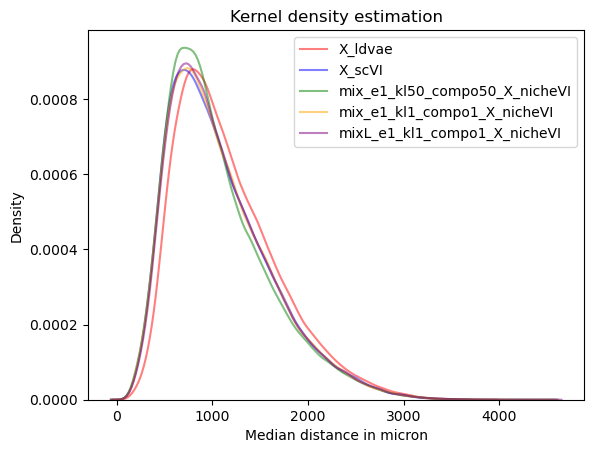

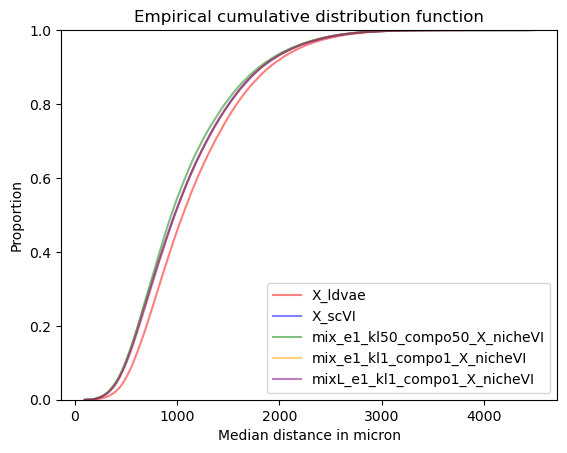

In [33]:
sa.plot_distance(plot_type="kde")
sa.plot_distance(plot_type="ecdf")

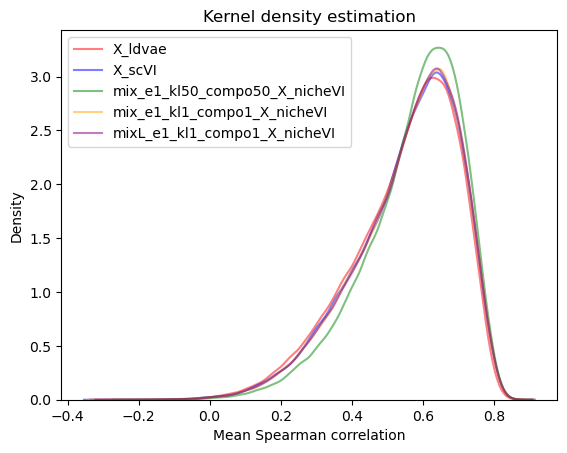

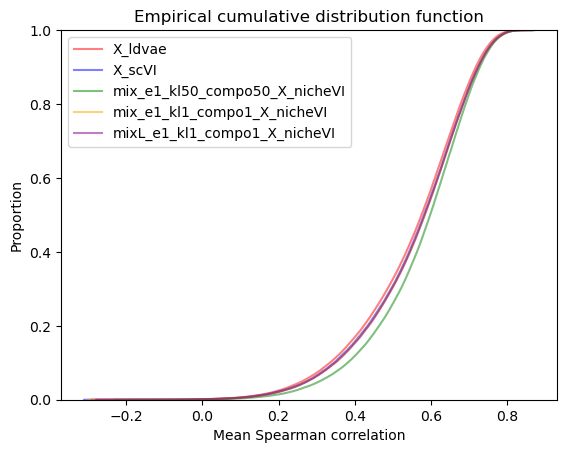

In [34]:
sa.plot_similarity(plot_type="kde")
sa.plot_similarity(plot_type="ecdf")

In [35]:
sa.test_distributions(test="mannwhitneyu", distribution="distance")

                                                     distance                                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model                         ┃ Mean distance ┃ Median distance ┃ p-value               ┃ p-value corrected     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ X_ldvae                       │ 1159.83       │ 1055.59         │ 0.0                   │ 0.0                   │
│ X_scVI                        │ 1082.91       │ 974.94          │ 1.0                   │ 1.0                   │
│ mix_e1_kl50_compo50_X_nicheVI │ 1060.69       │ 943.52          │ 9.195232633953584e-28 │ 2.298808158488396e-27 │
│ mix_e1_kl1_compo1_X_nicheVI   │ 1084.13       │ 975.83          │ 0.3061153116998371    │ 0.3826441396247963    │
│ mixL_e1_kl1_compo1_X_nicheVI  │ 1086.7        │ 976.2           │ 0.016866436991770192  │ 0.028110728319616987  │
└───────────────────────────────┴───────────────┴─────────────────┴───────────────────────┴───────────────────────┘

In [36]:
sa.test_distributions(test="mannwhitneyu", distribution="similarity")

                                                    similarity                                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model                   ┃ Mean similarity ┃ Median similarity ┃ p-value                ┃ p-value corrected      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ X_ldvae                 │ 0.55            │ 0.58              │ 4.626287268688967e-36  │ 1.1565718171722417e-35 │
│ X_scVI                  │ 0.56            │ 0.58              │ 1.0                    │ 1.0                    │
│ mix_e1_kl50_compo50_X_… │ 0.57            │ 0.6               │ 4.630910179448223e-176 │ 2.3154550897241116e-1… │
│ mix_e1_kl1_compo1_X_ni… │ 0.56            │ 0.58              │ 0.021678045960139714   │ 0.027097557450174642   │
│ mixL_e1_kl1_compo1_X_n… │ 0.56            │ 0.58              │ 0.006400266669358897   │ 0.010667111115598163   │
└─────────────────────────┴─────────────────┴───────────────────┴────────────────────────┴────────────────────────┘

In [56]:
sa.get_latent_overlap()

ValueError: Please run compute_spatial_metrics with the argument set_of_metrics=["latent_overlap"]

Computed leiden clusters for latent space: X_scVI

Computed leiden clusters for latent space: mix_e1_kl50_compo50_X_nicheVI

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


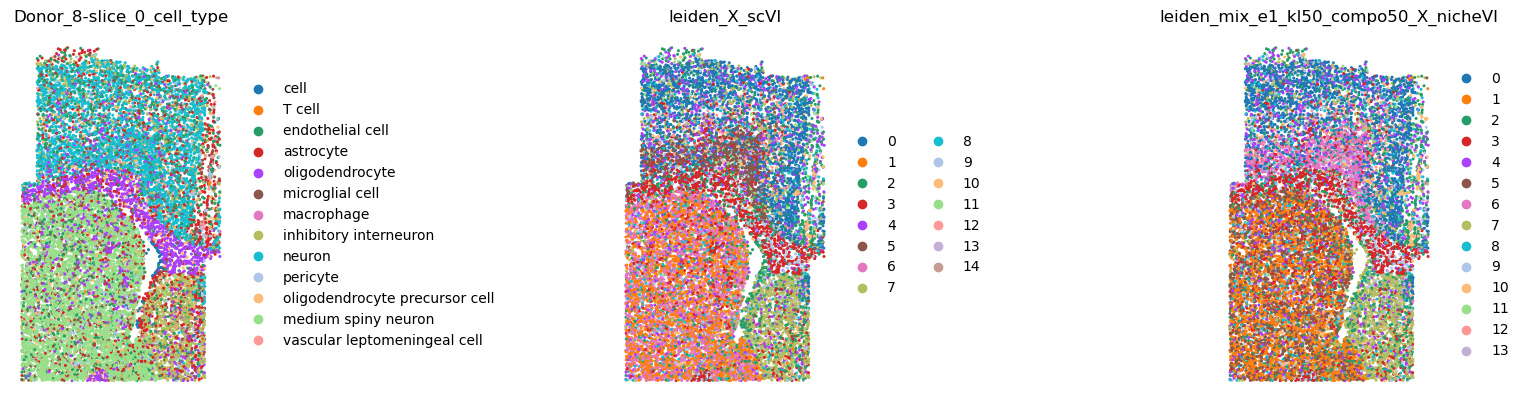

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


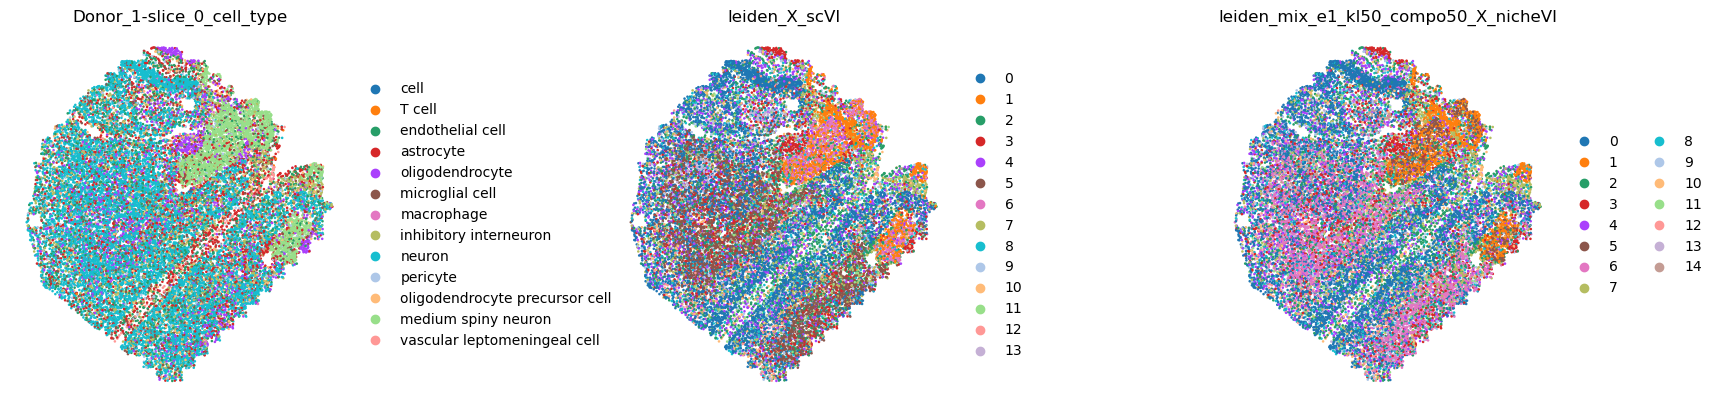

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


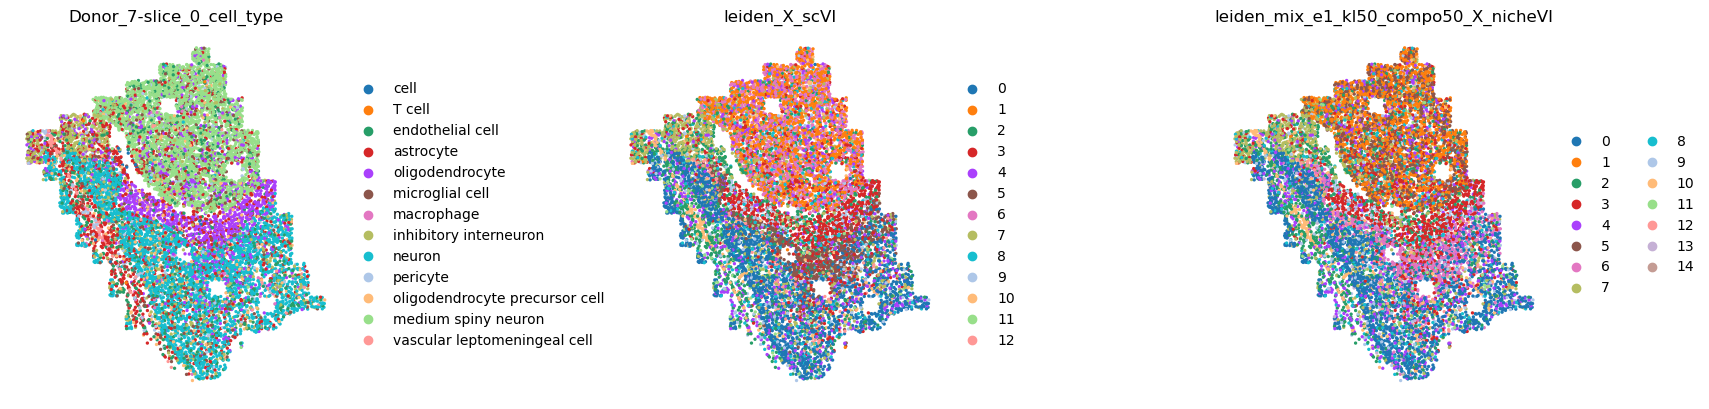

In [106]:
sa.show_clusters(
    resolution = 0.5,
    sample_subset=["Donor_8-slice_0", "Donor_1-slice_0", "Donor_7-slice_0"],
)

In [ ]:
# adata.write_h5ad("data/nicheVI.h5ad")

In [ ]:
adata = ad.read_h5ad("data/nicheVI.h5ad")

In [ ]:
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels', 'index'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap', 'qz1_m_niche_ct_prior', 'qz1_var_niche_ct_prior'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial', 
'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct', 
'qz1_var_niche_ct', 'X_nicheVI_cell_type_setup_mixture', 'X_nicheVI_cell_type_unweighted_setup_mixture', 'X_ldvae'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## EXPERIMENTS